<a href="https://colab.research.google.com/github/josephteh/QuantEcon.py/blob/master/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ECON 407: Final Project
### Predicting Macroeconomic Indicators: A Horserace Between VAR and Machine Learning Models
#### Joseph Teh

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
import datetime as dt
import warnings
warnings.simplefilter('ignore')

from sklearn import (linear_model, metrics, neural_network, pipeline, preprocessing, model_selection)
import statsmodels.formula.api as sm

plt.style.use("ggplot")

%matplotlib inline 

In [2]:
!pip install tensorflow
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM


Using TensorFlow backend.


In [5]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd drive/'My Drive'/'Colab Notebooks'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks


In [0]:
fred = pd.read_csv("fredmd.csv")

The data that I am using is constructed by Michael McCracken and Serena Ng: https://research.stlouisfed.org/econ/mccracken/fred-databases

In [7]:
# fred.info()
fred.head(5)

,sasdate,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
0,Transform:,5.000,5.0,5.000,5.0000,5.00000,5.0000,5.0000,5.0000,5.0000,...,6.000,6.00,6.00,6.00,2.0,6.0,6.0,6.0,6.0000,1.0
1,1/1/1959,2437.296,2288.8,17.302,292258.8329,18235.77392,22.6250,23.4581,22.1904,32.4078,...,11.358,2.13,2.45,2.04,NaN,274.9,6476.0,12298.0,84.2043,NaN
2,2/1/1959,2446.902,2297.0,17.482,294429.5453,18369.56308,23.0681,23.7747,22.3827,32.6455,...,11.375,2.14,2.46,2.05,NaN,276.0,6476.0,12298.0,83.5280,NaN
3,3/1/1959,2462.689,2314.0,17.647,293425.3813,18523.05762,23.4004,23.9186,22.4925,32.6455,...,11.395,2.15,2.45,2.07,NaN,277.4,6508.0,12349.0,81.6405,NaN
4,4/1/1959,2478.744,2330.3,17.584,299331.6505,18534.46600,23.8989,24.2641,22.8221,33.1606,...,11.436,2.16,2.47,2.08,NaN,278.1,6620.0,12484.0,81.8099,NaN


In [0]:
# Rename columns 
column_names = list(fred.columns.values)
transform = list(fred.iloc[0,:].values)

dictionary = dict(zip(column_names, transform))

for keys, values in enumerate(dictionary):
    if values == 5.0:
        dictionary["dlog_" + keys] = dictionary.pop(keys) 
    elif values == 2.0:
        dictionary["d_" + keys] = dictionary.pop(keys) 
    elif values == 3.0:
        dictionary["d2_" + keys] = dictionary.pop(keys) 
    elif values == 4.0:
        dictionary["log_" + keys] = dictionary.pop(keys)
    elif values == 6.0:
        dictionary["d2log_" + keys] = dictionary.pop(keys)
    elif values == 7.0:
        dictionary["dd_" + keys] = dictionary.pop(keys)

# new_columns = list(dictionary.keys())
# C = dict(zip(column_names, new_columns))
# fred = fred.rename(columns=C)

In [0]:
fred = fred.drop(0)
fred["sasdate"] = pd.to_datetime(fred["sasdate"])
fred = fred.rename(columns={"sasdate": "date"})
fred = fred.set_index("date")

In [10]:
fred.head(5)

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
date,,,,,,,,,,,,,,,,,,,,,
1959-01-01,2437.296,2288.8,17.302,292258.8329,18235.77392,22.6250,23.4581,22.1904,32.4078,21.9882,...,11.358,2.13,2.45,2.04,NaN,274.9,6476.0,12298.0,84.2043,NaN
1959-02-01,2446.902,2297.0,17.482,294429.5453,18369.56308,23.0681,23.7747,22.3827,32.6455,22.1036,...,11.375,2.14,2.46,2.05,NaN,276.0,6476.0,12298.0,83.5280,NaN
1959-03-01,2462.689,2314.0,17.647,293425.3813,18523.05762,23.4004,23.9186,22.4925,32.6455,22.5365,...,11.395,2.15,2.45,2.07,NaN,277.4,6508.0,12349.0,81.6405,NaN
1959-04-01,2478.744,2330.3,17.584,299331.6505,18534.46600,23.8989,24.2641,22.8221,33.1606,22.6807,...,11.436,2.16,2.47,2.08,NaN,278.1,6620.0,12484.0,81.8099,NaN
1959-05-01,2493.228,2345.8,17.796,301372.9597,18679.66354,24.2589,24.4655,23.0418,33.3190,23.1424,...,11.454,2.17,2.48,2.08,95.3,280.1,6753.0,12646.0,80.7315,NaN


### Data visualizations

In [0]:

# Define groups 
output_and_income = [
    "RPI", "W875RX1", "INDPRO", "IPFPNSS", "IPFINAL", "IPCCONGD", 
    "IPDCONGD", "IPNCONGD", "IPBUSEQ", "IPMAT", "IPDMAT", "IPNMAT", 
    "IPMANSICS", "IPB51222s", "IPFUELS", "NAPMPI", "CUMFNS"]

labor = ["HWI", "HWIURATIO", "CLF16OV", "CE16OV", "UNRATE", "UEMPMEAN", 
         "UEMPLT5", "UEMP5TO14", "UEMP15OV", "UEMP15T26", "UEMP27OV", 
         "CLAIMSx", "PAYEMS", "USGOOD", "CES1021000001", "USCONS", "MANEMP"
        "DMANEMP", "NDMANEMP", "SRVPRD", "USTPU", "USWTRADE", "USTRADE", 
        "USFIRE", "USGOVT", "CES0600000007", "AWOTMAN", "AWHMAN", "NAPMEI", 
        "CES0600000008", "CES2000000008", "CES3000000008"]

housing = ["HOUST", "HOUSTNE", "HOUSTMW", "HOUSTS", "HOUSTW", 
           "PERMIT", "PERMITNE", "PERMITMW", "PERMITS", "PERMITW"]

cons = ["DPCERA3M086SBEA", "CMRMTSPLx", "RETAILx", 
        "NAPM", "NAPMNOI", "NAPMSDI", "NAPMII", "ACOGNO", 
        "AMDMNOx", "ANDENOx", "AMDMUOx", "BUSINVx", "ISRATIOx", "UMCSENTx"]

money = ["M1SL", "M2SL", "M2REAL", "AMBSL", "TOTRESNS", 
         "NONBORRES", "BUSLOANS", "REALLN", "NONREVSL", "CONSPI", 
        "MZMSL", "DTCOLNVHFNM", "DTCTHFNM", "INVEST"]

interest = ["FEDFUNDS", "CP3Mx", "TB3MS", "TB6MS", "GS1", 
            "GS5", "GS10", "AAA", "BAA", "COMPAPFFx", "TB3SMFFM", 
            "TB6SMFFM", "T1YFFM", "T5YFFM", "T10YFFM", "AAAFFM", "BAAFFM", 
           "TWEXMMTH", "EXSZUSx", "EXJPUSx", "EXUSUKx", "EXCAUSx"]

prices = ["WPSFD49207", "WPSFD49502", "WPSID61", "WPSID62", "OILPRICEx", 
          "PPICMM", "NAPMPRI", "CPIAUCSL", "CPIAPPSL", "CPITRNSL", "CPIMEDSL", 
          "CUSR0000SAC", "CUSR0000SAD", "CUSR0000SAS", "CPIULFSL", "CUSR0000SA0L2", 
          "CUSR0000SA0L5", "PCEPI", "DDURRG3M086SBEA", "DNDGRG3M086SBEA", "DSERRG3M086SBEA"]

stocks = ["S&P 500", "S&P: indust", "S&P div yield", "S&P PE ratio", "VXOCLSx"]

def visuals(group, n1, n2, n3, n4, titlex):
    cols = [col for col in fred.columns if col in group]
    df = fred[cols]
    
    axs = df.plot(figsize=(n1,n2), subplots=True, legend=True, 
                  sharex=True, sharey=False, layout=(n3,n4), grid=False, title=titlex)
    return axs


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ffa85695ba8>,
      dtype=object)

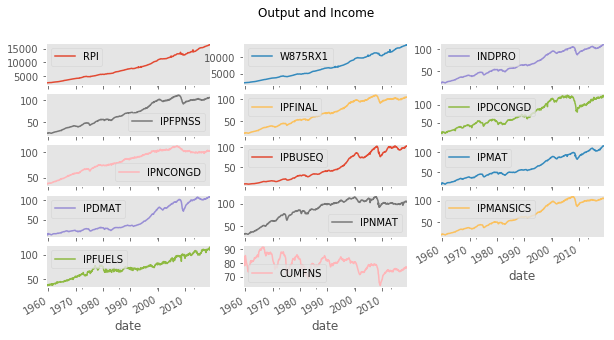

In [0]:
visuals(output_and_income, 10, 5, 5, 3, titlex="Output and Income")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ffa84915d68>,
      dtype=object)

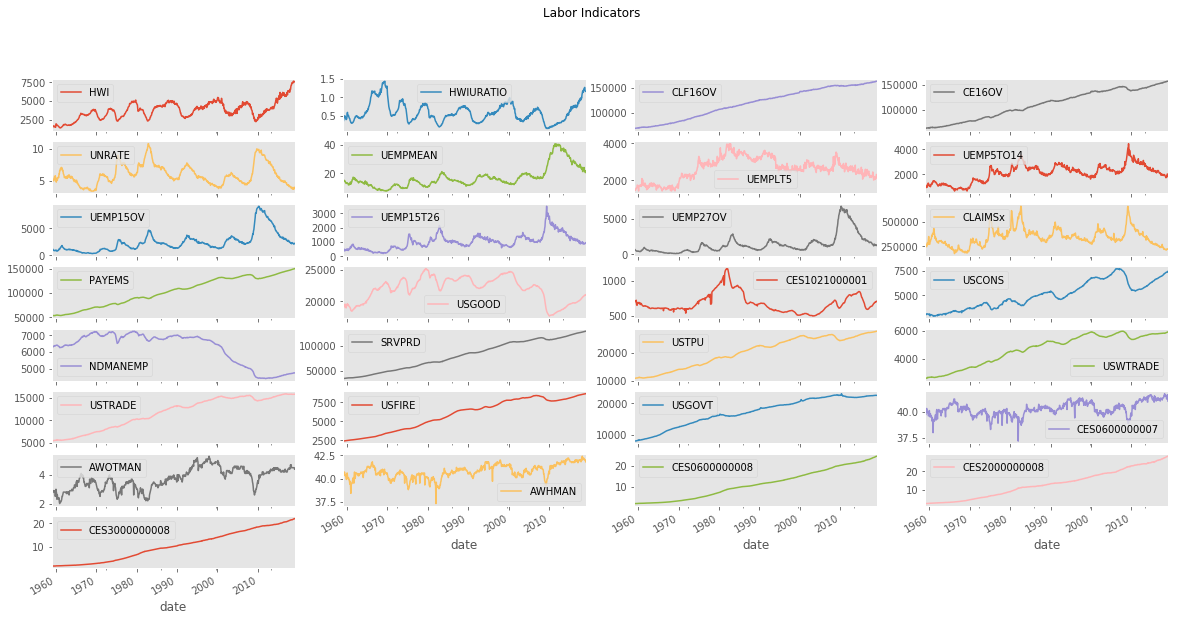

In [0]:
visuals(labor, 20, 10, 8, 4, titlex="Labor Indicators")

### Vector autoregressive models

In [0]:
from statsmodels.tsa.api import VAR

For the model, I am choosing stationary variables that are important for both labor and price measures. 
* UNRATE - Civilian Unemployment Rate
* CPIAUCSL -  CPI : All Items
* FEDFUNDS - Effective Federal Funds Rate
* TWEXMMTH -  Trade Weighted U.S. Dollar Index: Major Currencies
* RPI - Real Personal Income 
* HOUST - Housing Starts: Total New Privately Owned
* UMCSENTx - Consumer Sentiment Index


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcb2f0166a0>,
      dtype=object)

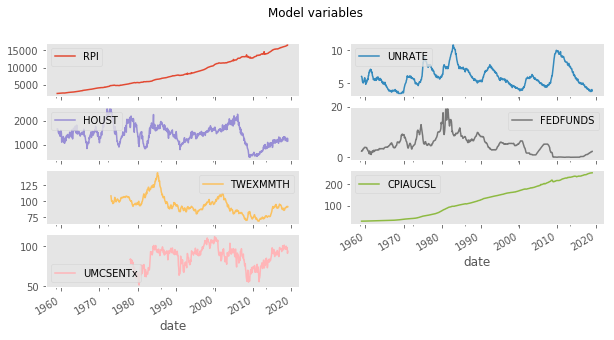

In [13]:
# Stationarity via visuals

model_vars = ["UNRATE", "CPIAUCSL", "FEDFUNDS", "TWEXMMTH", "RPI", "HOUST", "UMCSENTx"]
visuals(model_vars, 10, 5, 4, 2, titlex="Model variables")

RPI AND CPIAUCSL are not stationary The UNRATE, TWEXMMTH, UMCSENTx are somewhat stationary. We could still take the first difference of HOUST and FEDFUDNS to ensure true stationarity. 

In [0]:
# Rename variables
new_names = ["unrate", "cpi", "ffrt", "usd", "rpi", "houst", "csi"]
fred = fred.rename(columns=dict(zip(model_vars, new_names)))

In [0]:
# Make variables stationary through seasonal differencing

diff_variables = ["rpi", "cpi", "houst", "ffrt"]

for d in diff_variables:
    fred[d + "_diff"] = fred[d] - fred[d].shift(12)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f83d48ea978>,
      dtype=object)

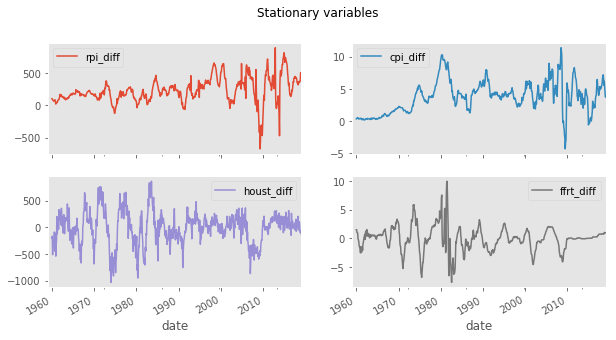

In [0]:
# Check stationarity again

diffs = ["rpi_diff", "cpi_diff", "houst_diff", "ffrt_diff"]
visuals(diffs, 10, 5, 2, 2, titlex="Stationary variables")

In [0]:
final_model = diffs + ["unrate", "usd", "csi"]
# fred[final_model].loc["1973-02-01":"1974-02-01",:]
var_fred = fred[final_model]

In [0]:
var_fred = var_fred.drop("csi", axis=1)
var_fred = var_fred.dropna(axis=0)

var_fred.index.to_period("M")

PeriodIndex(['1973-01', '1973-02', '1973-03', '1973-04', '1973-05', '1973-06',
             '1973-07', '1973-08', '1973-09', '1973-10',
             ...
             '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09',
             '2018-10', '2018-11', '2018-12', '2019-01'],
            dtype='period[M]', name='date', length=553, freq='M')

In [0]:
# dfuller_test(column="UNRATE")
# dfuller_test(column="CPIAUCSL")
# dfuller_test(column="FEDFUNDS")

Here, I want to use 75% of my sample data to forecast the rest of the period and then compare the forecast with the real values in the 25% of my sample for validation. This is not exactly "train-split-validate" in the traditional sense, because I am not fitting the VAR on the 25% of the data to predict inflation. For time series, it's rather tricky because of the use of lags. But this will probably give a good indicator of how well VAR performs.

In [0]:
fred_train = var_fred.loc["1973-01":"2009-01", :]
var_train = VAR(fred_train)
results = var_train.fit(12)

In [0]:
lag_order = results.k_ar
forecasted = pd.DataFrame(results.forecast(fred_train.values[-lag_order:], 120))

forecasted_names = list(forecasted.columns.values)
fred_train_names = list(fred_train.columns.values)

fred_dict = dict(zip(forecasted_names, fred_train_names))

for f, t in fred_dict.items():
    forecasted = forecasted.rename(columns={f:t + "_fcast"})

forecasted.head()

,rpi_diff_fcast,cpi_diff_fcast,houst_diff_fcast,ffrt_diff_fcast,unrate_fcast,usd_fcast
0,-147.532712,1.340401,-518.829033,-5.396807,8.110113,83.500592
1,-181.518712,1.664791,-392.825388,-6.913946,8.520520,85.953295
2,-261.304163,1.402223,-58.489624,-7.858023,8.594956,87.255258
3,-436.013348,0.619734,-114.336198,-8.088403,8.659683,87.972421
4,-379.719832,-0.194139,53.609844,-8.080831,8.748739,87.287772


In [0]:
forecasted.index = pd.DatetimeIndex(start="2009-02-01", periods=forecasted.shape[0], freq="MS")

In [0]:
forecasted.index.names = ["date"]
final_data = pd.merge(forecasted, var_fred, left_index=True, right_index=True)
final_data = final_data.sort_index(axis=0, ascending=True)
final_data.tail(5)

,rpi_diff_fcast,cpi_diff_fcast,houst_diff_fcast,ffrt_diff_fcast,unrate_fcast,usd_fcast,rpi_diff,cpi_diff,houst_diff,ffrt_diff,unrate,usd
date,,,,,,,,,,,,
2018-09-01,190.130541,4.269742,10.094009,-1.726992,6.256956,91.386936,364.249,5.592,79.0,0.80,3.7,89.9976
2018-10-01,193.760042,4.160693,29.580309,-1.718711,6.288788,91.364745,372.962,6.207,-56.0,1.04,3.8,90.7738
2018-11-01,198.244797,4.063233,47.552528,-1.695111,6.312867,91.339629,391.998,5.428,-97.0,1.04,3.7,91.6828
2018-12-01,203.962545,3.971904,64.107939,-1.655242,6.329531,91.313198,510.572,4.822,-70.0,0.97,3.9,92.0486
2019-01-01,210.751195,3.882239,79.572088,-1.599934,6.338744,91.284448,465.091,3.789,-61.0,0.99,4.0,91.1158


In [0]:
final_data = pd.concat([fred_train, final_data], sort=True, axis=0)
final_data = final_data.sort_index(axis=0, ascending=True)
final_data.head(5)

,cpi_diff,cpi_diff_fcast,ffrt_diff,ffrt_diff_fcast,houst_diff,houst_diff_fcast,rpi_diff,rpi_diff_fcast,unrate,unrate_fcast,usd,usd_fcast
date,,,,,,,,,,,,
1973-01-01,1.5,NaN,2.44,NaN,-13.0,NaN,338.678,NaN,4.9,NaN,108.1883,NaN
1973-02-01,1.6,NaN,3.29,NaN,-101.0,NaN,320.339,NaN,5.0,NaN,103.7461,NaN
1973-03-01,2.0,NaN,3.26,NaN,31.0,NaN,298.275,NaN,4.9,NaN,100.0000,NaN
1973-04-01,2.2,NaN,2.95,NaN,-165.0,NaN,301.222,NaN,5.0,NaN,100.8251,NaN
1973-05-01,2.3,NaN,3.57,NaN,45.0,NaN,303.224,NaN,4.9,NaN,100.0602,NaN


In [0]:
# Get the MSE of the forecast with the actual values

var_mse = metrics.mean_squared_error(final_data.loc["2009-02-01":"2019-01-01","cpi_diff_fcast"], 
                           final_data.loc["2009-02-01":"2019-01-01","cpi_diff"])

print (f"The mean squared error of the VAR in-sample forecast is {var_mse}")

The mean squared error of the VAR in-sample forecast is 6.501189870281187


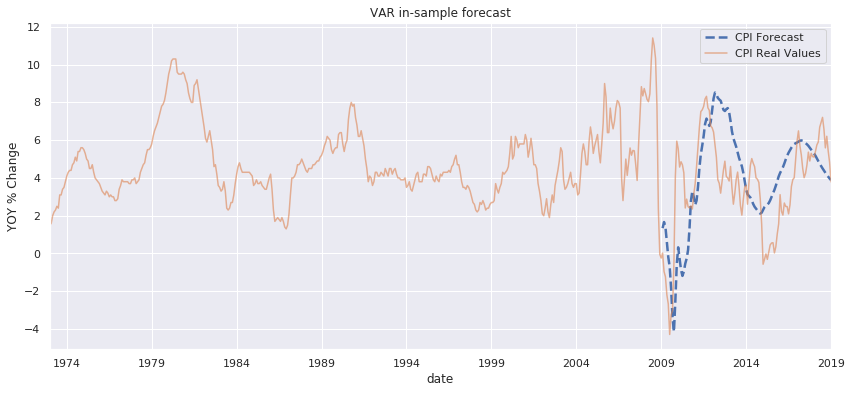

In [0]:
# Visualize the the forecast

sns.set()

fig1, ax1 = plt.subplots(figsize=(14,6))
colors = sns.color_palette("deep", 8)

final_data["cpi_diff_fcast"].plot(ax=ax1, legend=True, linewidth=2.5, linestyle="dashed")
final_data["cpi_diff"].plot(ax=ax1, legend=True, alpha=0.6, linestyle="solid")

ax1.set_title("VAR in-sample forecast")
ax1.set_ylabel("YOY % Change") # Try to add Markdown here \Delta instead of change

ax1.legend(["CPI Forecast", "CPI Real Values"])

Despite the high MSE, the visuals actually shows a smooth forecast of CPI that is pretty much trending together with the actual values. The VAR seems to perform quite well, at least when looking at the data visualization. 

### Machine Learning Models: Lasso and Neural Networks

Can they do better? If so, which features are important?

In [0]:
# Define train_test_split for time series
# Use the original FRED dataset

def timeseries_train_test_split(X, y, testsize):
    """
    This function splits the sample into a trained and test data
    """
    
    X_train = X.loc[:"2009-01-01"] # Until a particular date
    y_train = y.loc[:"2009-01-01"]
    X_test = X.loc["2009-01-01":]
    y_test = y.loc["2009-01-01":]
    
    return X_train, y_train, X_test, y_test

def train_test_plot(model, X_train, X_test):
    """
    This will plot the actual values of CPI against the one fitted by the model
    We train the model until 2009 and then use it from 2009 onwards on the test features dataset
    """
    fig, ax = plt.subplots(figsize=(14,6))
    colors = sns.color_palette("deep", 8)
    
    yvalues = pd.DataFrame(y_test)
    
    forecasted = list(model.predict(X_test)) # Use the model fit on features data from 2009 onwards
    df_fcast = pd.DataFrame({"date": list(yvalues.index), "cpi_fcast": forecasted})
    df_fcast = df_fcast.set_index("date")
    
    df = pd.merge(yvalues, df_fcast, left_index=True, right_index=True)

    df["cpi_fcast"].plot(ax=ax, legend=True, linewidth=2.5, linestyle="dashed") # CPI fitted
    df["CPIAUCSL_diff"].plot(ax=ax, legend=True, linewidth=1.5, linestyle="solid") # Actual CPI values
    
    ax.set_title("CPI vs. Model's CPI")
    ax.set_ylabel("YOY % Change")
    ax.legend(["Forecasted CPI","Actual CPI"])


Deal with stationarity first:

In [0]:
fred_2 = pd.read_csv("fredmd.csv")

fred_2 = fred_2.drop(0)
fred_2["sasdate"] = pd.to_datetime(fred_2["sasdate"])
fred_2 = fred_2.rename(columns={"sasdate": "date"})
fred_2 = fred_2.set_index("date")

for i in list(fred_2.columns.values):
    fred_2[i + "_diff"] = fred_2[i] - fred_2[i].shift(12)

cpi_target = fred_2.dropna().CPIAUCSL_diff
fred_features = fred_2.dropna().drop(["CPIAUCSL_diff"], axis=1) # Define function here for later on


In [0]:
fred_features = fred_features[list(fred_features.filter(regex = "_diff"))] # Drop non-stationary variables 
fred_features.head()

,RPI_diff,W875RX1_diff,DPCERA3M086SBEA_diff,CMRMTSPLx_diff,RETAILx_diff,INDPRO_diff,IPFPNSS_diff,IPFINAL_diff,IPCONGD_diff,IPDCONGD_diff,...,DSERRG3M086SBEA_diff,CES0600000008_diff,CES2000000008_diff,CES3000000008_diff,UMCSENTx_diff,MZMSL_diff,DTCOLNVHFNM_diff,DTCTHFNM_diff,INVEST_diff,VXOCLSx_diff
date,,,,,,,,,,,,,,,,,,,,,
1993-02-01,192.329,140.7,1.985,35659.610,9531.0,3.0683,3.4795,3.4619,4.3581,8.7039,...,1.916,0.26,0.24,0.27,17.8,199.2,-5260.0,7382.43,89.5458,-3.4258
1993-03-01,157.830,108.0,1.727,27576.732,8585.0,2.4446,2.8700,2.7552,3.5445,7.7066,...,1.970,0.26,0.23,0.26,9.9,180.5,-4611.0,5851.61,97.9279,-2.5297
1993-04-01,189.322,154.4,2.068,26577.795,12040.0,2.1912,2.5371,2.4683,2.9213,6.8202,...,1.943,0.26,0.22,0.27,8.4,169.1,-5260.0,7001.78,101.1875,-2.7319
1993-05-01,144.676,119.4,1.981,34513.435,12814.0,1.7472,1.8668,1.7028,1.7644,4.7302,...,2.182,0.28,0.25,0.26,1.1,182.8,-3061.0,5760.34,94.8919,-1.1930
1993-06-01,101.011,69.9,2.041,33845.785,12080.0,1.8486,2.0007,1.8451,2.3105,4.9800,...,2.195,0.25,0.14,0.27,1.1,178.8,-2013.0,4475.24,95.9206,-1.7509


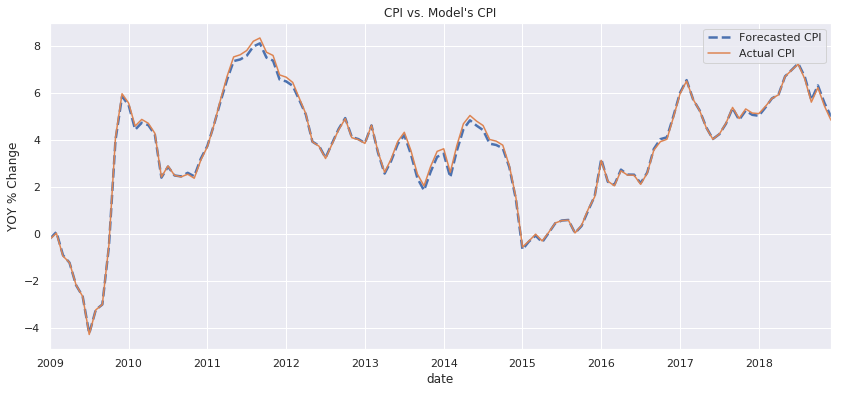

In [0]:
X_train, y_train, X_test, y_test = timeseries_train_test_split(X=fred_features, y=cpi_target, testsize=0.25)

lasso = linear_model.LassoCV(cv=model_selection.TimeSeriesSplit(n_splits=5), 
                             alphas=None, tol = 10000, normalize=True) # Returns over 5 "folds"
# The folds here are different in the sense that it is done on a rolling basis. Data is folded across the time observations

fred_lasso = lasso.fit(X_train, y_train)
optimal_alpha = fred_lasso.alpha_

lasso2 = linear_model.Lasso(alpha=optimal_alpha, normalize=True)
lasso2.fit(X_train, y_train)

train_test_plot(lasso2, X_train, X_test) 

In [0]:
metrics.mean_squared_error(y_test, lasso2.predict(X_test)) # Very low MSE

0.01135618313088171

The MSE is actually quite amazingly small. Showing that the test data fitted into Lasso actually predicts CPI very well and closely with the actual values.

In [0]:
lasso_coefs = pd.DataFrame({"features":list(X_train), "coef": lasso2.coef_})
lasso_coefs = lasso_coefs[lasso_coefs.coef != 0.0]
lasso_coefs
## lasso_coefs.nlargest(5, columns="coef") # Why isn't this giving me what I need?

,features,coef
2,DPCERA3M086SBEA_diff,-6.092001e-03
10,IPNCONGD_diff,-7.208324e-04
26,UEMP5TO14_diff,5.313467e-06
51,HOUSTW_diff,-3.503193e-05
56,PERMITW_diff,-5.913313e-05
59,ANDENOx_diff,-2.013814e-07
66,AMBSL_diff,-2.223315e-04
68,NONBORRES_diff,-4.813950e-08
101,WPSID61_diff,7.068179e-04
103,OILPRICEx_diff,3.761202e-05


Seems like DPCERA3M086SBEA_diff, UEMP5TO14_diff, PERMITW_diff, WPSID61_diff, IPNCONGD_diff appear to be the most important. Can use them in VAR below for the forecast. 

In [0]:
var_fred2 = fred_2[["CPIAUCSL_diff","DPCERA3M086SBEA_diff", "UEMP5TO14_diff", 
                    "PERMITW_diff", "WPSID61_diff", "IPNCONGD_diff"]]

var_fred2 = var_fred2.dropna(axis=0)
# var_fred2.head()

var_fred2.index.to_period("M")

fred_train2 = var_fred2.loc["1973-01":"2009-01", :] # Same sample length as baseline VAR
var_train2 = VAR(fred_train2)
results2 = var_train2.fit(12)

lag_order2 = results2.k_ar
forecasted2 = pd.DataFrame(results2.forecast(fred_train2.values[-lag_order:], 120))

forecasted_names2 = list(forecasted2.columns.values)
fred_train_names2 = list(fred_train2.columns.values)

fred_dict2 = dict(zip(forecasted_names2, fred_train_names2))

for f, t in fred_dict2.items():
    forecasted2 = forecasted2.rename(columns={f:t + "_fcast"})

# forecasted2.head()

forecasted2.index = pd.DatetimeIndex(start="2009-02-01", periods=forecasted2.shape[0], freq="MS")
forecasted2.index.names = ["date"]
final_data2 = pd.merge(forecasted2, var_fred2, left_index=True, right_index=True)
final_data2 = final_data2.sort_index(axis=0, ascending=True)
final_data2.tail(5)

,CPIAUCSL_diff_fcast,DPCERA3M086SBEA_diff_fcast,UEMP5TO14_diff_fcast,PERMITW_diff_fcast,WPSID61_diff_fcast,IPNCONGD_diff_fcast,CPIAUCSL_diff,DPCERA3M086SBEA_diff,UEMP5TO14_diff,PERMITW_diff,WPSID61_diff,IPNCONGD_diff
date,,,,,,,,,,,,
2018-09-01,5.093142,1.467431,287.267458,-9.562374,3.704146,0.382768,5.592,3.067,-180.0,7.0,11.3,1.9748
2018-10-01,4.972520,1.501042,282.167590,0.906143,3.395660,0.552743,6.207,3.262,-112.0,-60.0,11.6,1.3222
2018-11-01,4.851797,1.533778,268.913682,10.221553,3.131884,0.729681,5.428,3.252,-77.0,-36.0,8.3,1.8375
2018-12-01,4.705562,1.563783,246.735800,17.876872,2.854898,0.886381,4.822,2.369,43.0,16.0,5.9,-0.2924
2019-01-01,4.525055,1.591656,217.555557,24.187855,2.525768,1.005831,3.789,2.643,86.0,-39.0,1.6,-0.1358


In [0]:
final_data2 = pd.concat([fred_train2, final_data2], sort=True, axis=0)
final_data2 = final_data2.sort_index(axis=0, ascending=True)
final_data2.head(5)

,CPIAUCSL_diff,CPIAUCSL_diff_fcast,DPCERA3M086SBEA_diff,DPCERA3M086SBEA_diff_fcast,IPNCONGD_diff,IPNCONGD_diff_fcast,PERMITW_diff,PERMITW_diff_fcast,UEMP5TO14_diff,UEMP5TO14_diff_fcast,WPSID61_diff,WPSID61_diff_fcast
date,,,,,,,,,,,,
1973-01-01,1.5,NaN,2.419,NaN,2.3953,NaN,-65.0,NaN,-145.0,NaN,2.3,NaN
1973-02-01,1.6,NaN,2.544,NaN,2.6721,NaN,-97.0,NaN,-207.0,NaN,2.7,NaN
1973-03-01,2.0,NaN,2.101,NaN,2.6665,NaN,-40.0,NaN,-78.0,NaN,3.3,NaN
1973-04-01,2.2,NaN,1.885,NaN,1.9356,NaN,-56.0,NaN,-26.0,NaN,3.4,NaN
1973-05-01,2.3,NaN,1.800,NaN,2.7703,NaN,-80.0,NaN,-214.0,NaN,4.2,NaN


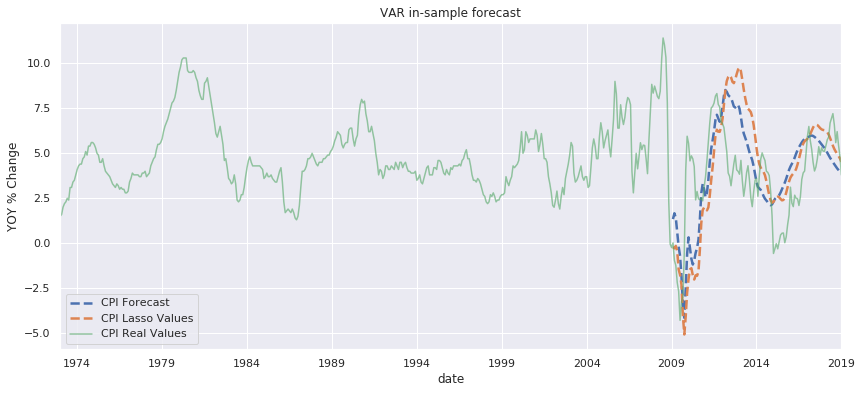

In [0]:
fig1, ax1 = plt.subplots(figsize=(14,6))
colors = sns.color_palette("deep", 8)

final_data["cpi_diff_fcast"].plot(ax=ax1, legend=True, linewidth=2.5, linestyle="dashed")
final_data2["CPIAUCSL_diff_fcast"].plot(ax=ax1, legend=True, linewidth=2.5, linestyle="dashed")
final_data["cpi_diff"].plot(ax=ax1, legend=True, alpha=0.6, linestyle="solid")

ax1.set_title("VAR in-sample forecast")
ax1.set_ylabel("YOY % Change") # Try to add Markdown here \Delta instead of change

ax1.legend(["CPI Forecast", "CPI Lasso Values", "CPI Real Values"])

In [0]:
var_mse2 = metrics.mean_squared_error(final_data2.loc["2009-02-01":"2019-01-01","CPIAUCSL_diff_fcast"], 
                           final_data2.loc["2009-02-01":"2019-01-01","CPIAUCSL_diff"])

print (f"The mean squared error of the VAR in-sample forecast is {var_mse2}")

The mean squared error of the VAR in-sample forecast is 10.054163365944701


Not too great. Doesn't show that Lasso helps our VAR. Conclusion: This shows the limits of machine learning in helping construct a proper VAR.

#### Neural Networks (MLP)

I adapted the following code from similar time series projects online that use neural networks for prediction. The goal is to obtain the features selected by the neural network model to use in my VAR.

In [0]:
# !pip install eli5

# Use the keras package, which specializes in neural networks even for time series 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# # For scaling purposes
# from preprocessing import MinMaxScaler

# # eli5 package can get the features
# from eli5.sklearn import PermutationImportance
# from eli5 import show_weights

In [0]:
# Build the neural network 

# Normalize the features 
scaler = MinMaxScaler(feature_range=(0,1))
scaled_fred = scaler.fit_transform(fred_2.values)

# Wrap this in some function above; stationary
for i in list(fred_2.columns.values):
    fred_2[i + "_diff"] = fred_2[i] - fred_2[i].shift(12)
    
cpi_target2 = scaled_fred.dropna().CPIAUCSL_diff 
fred_features2 = scaled_fred.dropna().drop(["CPIAUCSL_diff"], axis=1)

fred_features2 = fred_features2[list(fred_features2.filter(regex = "_diff"))]

# Split the dataset
X_train, y_train, X_test, y_test = timeseries_train_test_split(X=fred_features2, y=cpi_target2, testsize=0.25)

# Reshape inputs to be 3D
X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build model
nn_model = Sequential() # The simplest kind of model; a linear stack of layers
nn_model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]))) # 50 neurons in the first layer
nn_model.add(Dense(1))
model = nn_model.compile(loss="mean_squared_error", optimizer="adam", )

# Fit
model.fit(X_train, y_train, epochs=60, batch_size=30,
                                validation_data=(X_test, y_test), verbose=2,
                                shuffle=False)

# Evaluate the model
# In order to get the MSE, we need to do invert scaling
# Inverse scaling for forecast
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))
inv_yhat = np.concatenate((model.predict(X_test), X_test), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_y[:,-1]

# Invert scaling for actual values
y_test = y_test.reshape((len(y_test), 1))
inv_y = np.concatenate((y_test, X_test), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]

mse = metrics.mean_squared_error(y_test, model.predict(X_test))

In [0]:
# train_test_plot(nn_model, X_train, X_test)